In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.optimize import curve_fit
import os

In [2]:
data_folder = '/Users/layden/Downloads/AtikPythonSDK/'
linearity_files = os.listdir(data_folder)
linearity_files = [f for f in linearity_files if f.endswith('.fits')]
linearity_files = [f for f in linearity_files if not f.startswith('._')]
print(linearity_files)

['stack_4_ms.fits', 'stack_23_ms.fits', 'stack_32_ms.fits', 'stack_7278_ms.fits', 'stack_221_ms.fits', 'stack_2043_ms.fits', 'stack_161_ms.fits', 'stack_17_ms.fits', 'stack_6_ms.fits', 'stack_417_ms.fits', 'stack_12_ms.fits', 'stack_117_ms.fits', 'stack_3_ms.fits', 'stack_573_ms.fits', 'stack_788_ms.fits', 'stack_2_ms.fits', 'stack_2807_ms.fits', 'stack_85_ms.fits', 'stack_1487_ms.fits', 'stack_5298_ms.fits', 'stack_303_ms.fits', 'stack_9_ms.fits', 'stack_45_ms.fits', 'stack_10000_ms.fits', 'stack_1082_ms.fits', 'stack_3856_ms.fits', 'stack_1_ms.fits', 'stack_62_ms.fits']


In [6]:
exp_times = np.zeros(len(linearity_files))
mean_vals = np.zeros(len(linearity_files))
var_vals = np.zeros(len(linearity_files))
for i, file in enumerate(linearity_files[:]):
    with fits.open(os.path.join(data_folder, file)) as hdul:
        # Convert to signed integer
        data = hdul[0].data.astype(np.int32)
        exp_times[i] = hdul[0].header['EXPTIME']
        # Different number of frames for each exposure time, so just take first 10
        mean_vals[i] = np.mean(data[2:10])
        var_vals[i] = np.mean(np.var(data[2:10], axis=0, ddof=1))
    print(f"Mean value for exposure time {exp_times[i]}: {mean_vals[i]}. Variance: {var_vals[i]}.")

Mean value for exposure time 0.004893900826573372: 101.80169935680371. Variance: 58.18505229839702.
Mean value for exposure time 0.02395026572048664: 118.47815710170804. Variance: 91.27544201447661.
Mean value for exposure time 0.03290344402194023: 126.59351395935306. Variance: 107.13689004094928.
Mean value for exposure time 7.278954029083252: 6760.682908393878. Variance: 13097.22921914272.
Mean value for exposure time 0.22122162580490112: 298.8216352151768. Variance: 458.0389351772542.
Mean value for exposure time 2.0433597564697266: 1969.5440580884192. Variance: 3757.768709160418.
Mean value for exposure time 0.1610262095928192: 243.2657356475698. Variance: 343.99689078984176.
Mean value for exposure time 0.01743328757584095: 112.30385380493422. Variance: 79.08522280368288.
Mean value for exposure time 0.006723357364535332: 103.56078117757167. Variance: 61.68556677159945.
Mean value for exposure time 0.41753190755844116: 481.26029913226773. Variance: 798.0544796558362.
Mean value fo

In [29]:
# Sort the exposure times and mean values
sorted_indices = np.argsort(exp_times)
exp_times = exp_times[sorted_indices]
mean_vals = mean_vals[sorted_indices]
var_vals = var_vals[sorted_indices]
bias_level = mean_vals[0]
mean_vals = mean_vals - bias_level

[914.97582773  -1.53571802]


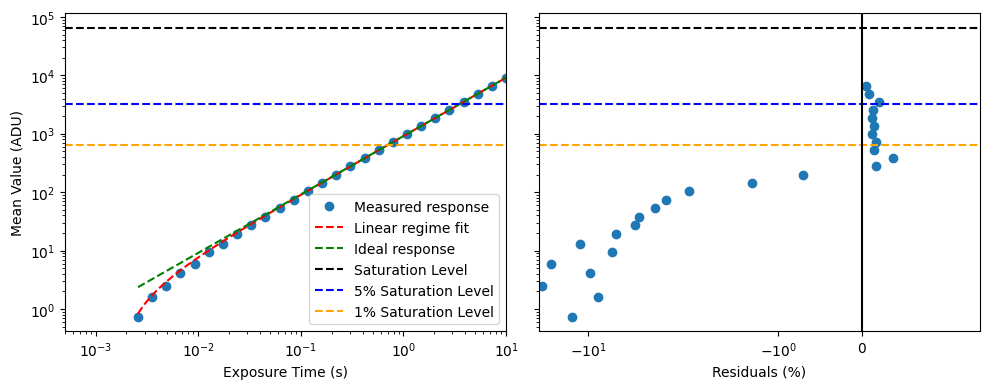

In [30]:
%matplotlib inline
popt, pcov = curve_fit(lambda x, a, b: a * x + b, exp_times[5:], mean_vals[5:])
print(popt)
x_fit = np.logspace(np.log10(exp_times[1]), np.log10(exp_times[-1]), 100)
y_fit = popt[0] * x_fit + popt[1]
y_fit2 = popt[0] * x_fit
residuals = mean_vals[1:-1] - popt[0] * exp_times[1:-1] - popt[1]
residuals_percent = (residuals / mean_vals[1:-1]) * 100
# Twin y axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
ax1.plot(exp_times, mean_vals, 'o', label='Measured response')
ax1.plot(x_fit, y_fit, 'r--', label='Linear regime fit')
ax1.plot(x_fit, y_fit2, 'g--', label='Ideal response')
ax1.axhline(y=2**16, color='k', linestyle='--', label='Saturation Level')
ax1.axhline(y=2**16 * 0.05, color='b', linestyle='--', label='5% Saturation Level')
ax1.axhline(y=2**16 * 0.01, color='orange', linestyle='--', label='1% Saturation Level')
ax1.legend()
ax1.set_xlabel('Exposure Time (s)')
ax1.set_ylabel('Mean Value (ADU)')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(0.0005, 10)
ax2.plot(residuals_percent, mean_vals[1:-1], 'o')
ax2.axhline(y=2 ** 16, color='k', linestyle='--')
ax2.axhline(y=2**16 * 0.05, color='b', linestyle='--')
ax2.axhline(y=2**16 * 0.01, color='orange', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='-')
ax2.set_xlabel('Residuals (%)')
ax2.set_yscale('log')
ax2.set_xscale('symlog')
plt.tight_layout()

[ 1.96043054 54.03992469]


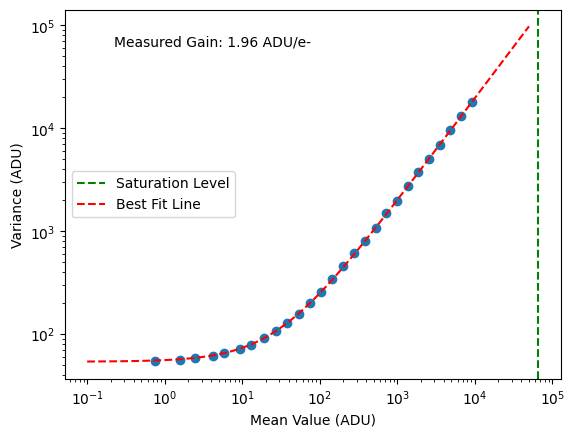

In [26]:
%matplotlib inline
plt.plot(mean_vals, var_vals, 'o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Mean Value (ADU)')
plt.ylabel('Variance (ADU)')
plt.axvline(x=2 ** 16, color='g', linestyle='--', label='Saturation Level')
# popt2, pcov2 = curve_fit(lambda x, a, b: a * x + b, (mean_vals - bias_level)[:-2], var_vals[:-2],
#                          p0=[8, 10], wei
# Do a weighted linear fit
popt2, pcov2 = curve_fit(lambda x, a, b: a * x + b, mean_vals[:], var_vals[:],
                         p0=[8, 10], sigma=var_vals[:] ** 0.5)
x_fit2 = np.logspace(-1, np.log10(50000), 100)
y_fit2 = popt2[0] * x_fit2 + popt2[1]
plt.plot(x_fit2, y_fit2, 'r--', label='Best Fit Line')
plt.legend()
# Put text with gain on plot
print(popt2)
gain = popt2[0]
plt.text(0.1, 0.9, f'Measured Gain: {gain:.2f} ADU/e-', transform=plt.gca().transAxes)
# plt.text(0.1, 0.85, f'Datasheet Gain: {1/0.114:.2f} ADU/e-', transform=plt.gca().transAxes)
# plt.ylim(500, 1E6)
plt.show()